In [4]:
from pathlib import Path
import tensorflow as tf

2025-10-16 09:34:04.825419: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Problem #1: Generating a Normalized Coordinate Grid
**Source** : Gemini

**Context**
In many computer vision tasks, particularly in object detection (e.g., YOLO, SSD), we divide an image into a grid. Each cell in this grid is responsible for predicting objects located within it. To do this, the model needs to know the location of each grid cell. Your task is to generate a tensor that contains the normalized (x, y) coordinates of the center of each cell.

**Your Task**
Write a Python function generate_normalized_grid(grid_size) that takes an integer grid_size and returns a TensorFlow tensor with the following properties:

**Shape**: (grid_size, grid_size, 2)

**Data Type**: tf.float32

**Content**: The tensor should represent a grid where the last dimension [..., 0] holds the normalized x-coordinates and [..., 1] holds the normalized y-coordinates. The coordinates must be normalized to the range [0.0, 1.0).

**Normalization Logic**: For a grid of size N, the center of the cell at (row, col) has coordinates ((col + 0.5) / N, (row + 0.5) / N).

**Example**
If grid_size = 2, the expected output tensor is:
```python
<tf.Tensor: shape=(2, 2, 2), dtype=float32, numpy=
[[[0.25, 0.25],  # Cell at (row=0, col=0) -> (x=0.25, y=0.25)
  [0.75, 0.25]], # Cell at (row=0, col=1) -> (x=0.75, y=0.25)

 [[0.25, 0.75],  # Cell at (row=1, col=0) -> (x=0.25, y=0.75)
  [0.75, 0.75]]]># Cell at (row=1, col=1) -> (x=0.75, y=0.75)
```
Notice how the x-coordinate increases along the columns and the y-coordinate increases along the rows.


## Thoughts
* So here we need a vectorized solution that creates a tensor whose values depend on its indices.
* I think it would help to initialize the grid cells with index values. 
* We can initialize the grid with zeroes and then use `scatter_nd_update` to update the row cells and column cells.

### Update
* Found a simpler way to do this, created 2 colums using tf.range and tf.repeat and combined it to create a tensor grid where each cell value represented its coordinate value.
* After that calculation was as simple as broadcasting addition and division 


## Solution 1

In [6]:
@tf.function
def generate_normalized_grid(grid_size = 2):
    ## step 1 - get the grid indices range
    grid_range = tf.range(grid_size, dtype=tf.float32)
    ## create column 0 for the grid - this column represents the x-coordinate of each grid cell
    ## value indices of this column would be 0,0,1,1 for grid_size 2
    col_0 = tf.reshape(tf.repeat(grid_range,repeats=grid_size), shape=(grid_size,grid_size,1))
    ## create column 1 for the grid - this column represents y-coordinate of each cell
    col_1 = tf.reshape(tf.repeat([grid_range],repeats=grid_size,axis=0),shape=(grid_size,grid_size,1))
    ## concatenate to form our grid
    ## currently each grid cell represents it index value in float. 
    grid = tf.concat(values = [col_1,col_0], axis = 2)
    ## calculate the grid cell center. 
    coordinate_grid = (grid + 0.5)/grid_size
    return coordinate_grid

In [7]:
generate_normalized_grid()

I0000 00:00:1760632449.423652   20028 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6053 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:2e:00.0, compute capability: 7.5


<tf.Tensor: shape=(2, 2, 2), dtype=float32, numpy=
array([[[0.25, 0.25],
        [0.75, 0.25]],

       [[0.25, 0.75],
        [0.75, 0.75]]], dtype=float32)>

## Solution 2 - using tf.meshgrid

In [8]:


def generate_grid_cooridinates(grid_size = 2):
    # 1. Create a 1D vector for x indices: [0, 1, 2, ...]
    coorinate_range = tf.range(grid_size, dtype=tf.float32)
    grid_X,grid_Y = tf.meshgrid(coorinate_range,coorinate_range)
    coordinate_grid = tf.stack(values=[grid_X,grid_Y], axis=2)
    return coordinate_grid
    
def generate_normalized_grid(grid_size = 2):
    coordinate_grid = generate_grid_cooridinates(grid_size=grid_size)
    normalized_grid = (coordinate_grid + 0.5) / grid_size
    return normalized_grid


In [9]:
normalized_grid = generate_normalized_grid()

# Problem #2 : Scaling the Grid to Image Coordinates
**Source**: Gemini

**Context**
In our object detection project, the normalized grid you just created is a generic, resolution-independent representation. However, to actually use it with a specific image, we need to convert those [0.0, 1.0) coordinates into actual pixel coordinates. For example, the center of the top-left cell in a 13x13 grid might be (0.038, 0.038) in normalized space, but on a 416x416 pixel image, that corresponds to pixel (16, 16).

**Your Task**
Write a Python function `scale_grid_to_pixels(normalized_grid, image_shape)` that takes two arguments:

**normalized_grid**: The output tensor from our previous problem, with shape (grid_size, grid_size, 2).

**image_shape**: A 1D TensorFlow tensor or a Python tuple/list of two integers, **`[height, width]`**.

The function should return a new tensor with the same shape as normalized_grid, but where the (x, y) coordinates have been scaled to the pixel space of the image.

**Scaling Logic**:

`pixel_x = normalized_x * width`

`pixel_y = normalized_y * height`

**Example**:
Given the normalized_grid for grid_size = 2:
```
[[[0.25, 0.25], [0.75, 0.25]],
 [[0.25, 0.75], [0.75, 0.75]]]
```
And an image_shape of [416, 416], the expected output is:
```
<tf.Tensor: shape=(2, 2, 2), dtype=float32, numpy=
[[[104., 104.],  # (0.25*416, 0.25*416)
  [312., 104.]], # (0.75*416, 0.25*416)

 [[104., 312.],  # (0.25*416, 0.75*416)
  [312., 312.]]]># (0.75*416, 0.75*416)
```
**Important**: Note the order. The image_shape is (height, width), but our coordinate grid is (x, y). Your solution will need to handle this correctly.

## Thoughts
* First impression of this problem is that this is straight forward, just a simple multiplication. Lets try that and see

In [10]:
@tf.function
def scale_grid_to_pixels(normalized_grid, image_shape):
    ## cast to float32
    img_shape_float = tf.cast(image_shape, dtype=tf.float32)
    ## reorder the image shape colums so that we multiply normalized_x with width and normalized_y with height
    reordered_column = tf.gather(params=img_shape_float, indices=[1,0],axis=0)
    scaled_grid = tf.multiply(normalized_grid, reordered_column)
    return scaled_grid

In [11]:
image_shape = tf.constant(value=[416,416])
scale_grid_to_pixels(normalized_grid=normalized_grid,image_shape=image_shape)

<tf.Tensor: shape=(2, 2, 2), dtype=float32, numpy=
array([[[104., 104.],
        [312., 104.]],

       [[104., 312.],
        [312., 312.]]], dtype=float32)>

# Problem #3: Batch-Scaling Grids for Multiple Images

**Context**
To train a neural network efficiently, we process multiple images at once in a "batch". Our grid scaling logic needs to support this. We'll have one common normalized_grid, but a list of different image shapes—one for each image in the batch. Your task is to perform the scaling operation for the entire batch in a single, vectorized call.

**Your Task**
Write a function batch_scale_grids(normalized_grid, batch_image_shapes) that takes:

`normalized_grid: The (grid_size, grid_size, 2) tensor from Problem #1.`

`batch_image_shapes: A 2D tensor of shape (batch_size, 2), where each row is an [height, width] pair.`

The function should return a single tensor of shape (batch_size, grid_size, grid_size, 2) containing the scaled grid for each image.

**Example**
Given normalized_grid (for grid_size=2) and batch_image_shapes:

```python
# A batch of 2 images with different shapes
batch_image_shapes = tf.constant([[416, 416],  # Image 1 is 416x416
                                  [800, 600]], # Image 2 is 800x600 (WxH) -> No, (HxW)
                                 dtype=tf.int32)
```
The goal is to multiply the single (2, 2, 2) normalized grid with the (2, 2) batch of shapes to produce a (2, 2, 2, 2) - (batch_size, grid_size, grid_size, 2) output tensor.

## Thoughts
* This is interesting, the shape of both these tensors are different, so direct tensor multiplication won't work. 
* We can try and use `tf.newaxis` to add axis to normalized grid and then do a tf.reshape to get the desired output. 
* We'll also need to reorder elements of batch image shape like we did before. 

In [12]:
def batch_normalized_grid(normalized_grid, batch_image_shapes):
    batch_image_shapes_float = tf.cast(batch_image_shapes, dtype=tf.float32)
    ## reorder the values
    batch_image_shapes_float_reordered = tf.reverse(batch_image_shapes_float, axis=[-1])
    ## add additional axis
    batch_image_shapes_float_reordered = batch_image_shapes_float_reordered[:,tf.newaxis,tf.newaxis,:]
    normalized_grid_expanded = normalized_grid[tf.newaxis,:]
    ## this will give us batch_image_shape as (batch_size,1,1,2) and normalized grid as (1,grid_size,grid_size,2)
    ## multiplying these two will give us (batch_size, grid_size,grid_size,2)
    normalized_grid = tf.multiply(normalized_grid_expanded,batch_image_shapes_float_reordered)
    return normalized_grid

In [13]:
batch_image_shapes = tf.constant([[416, 416],  # Image 1 is 416x416
                                  [800, 600]], # Image 2 is 800x600 (WxH) -> No, (HxW)
                                 dtype=tf.int32)

normalized_grids = batch_normalized_grid(normalized_grid=normalized_grid, batch_image_shapes=batch_image_shapes)


# Problem #4: Generating Anchor Box Grids

## **Context**

So far, we have the coordinates for the *center* of each grid cell. In modern object detectors (like YOLO), each grid cell doesn't just predict one object; it's responsible for several "anchor boxes" of different pre-defined shapes and sizes (e.g., a tall box, a wide box, a large square box). The model's job isn't to predict a box from scratch, but rather to predict small *adjustments* to the closest matching anchor box.

Our task is to generate the full set of anchor boxes for every grid cell across every image in our batch.

## **Your Task**

Write a function `generate_anchor_grids(scaled_grids, anchor_boxes)` that takes:

1.  `scaled_grids`: The output from our previous problem—a tensor of pixel coordinates for the grid centers, with shape `(batch_size, grid_size, grid_size, 2)`.
2.  `anchor_boxes`: A 2D tensor of shape `(num_anchors, 2)`, where each row is a `[width, height]` pair for a pre-defined anchor.

The function should return a tensor of shape `(batch_size, grid_size, grid_size, num_anchors, 4)`. This final tensor represents the specific bounding boxes (in `[x_min, y_min, x_max, y_max]` format) for every anchor at every grid location.

**Calculation Logic**:
For each grid center `(cx, cy)` from `scaled_grids` and each anchor size `(w, h)` from `anchor_boxes`:
* `x_min = cx - w / 2`
* `y_min = cy - h / 2`
* `x_max = cx + w / 2`
* `y_max = cy + h / 2`

**Core Challenge**: This is another broadcasting puzzle, but with more dimensions. You'll need to expand both `scaled_grids` and `anchor_boxes` so you can perform the `center +/- size/2` calculation. After calculating the `min` and `max` coordinates, you will need to combine them to form the final `(..., 4)` dimension.

This is the most complex problem yet, but it uses the exact same principles you've already mastered. Good luck!

In [14]:
@tf.function
def generate_anchor_grids(scaled_grids, anchor_boxes):
    ## step 1: add axis to scaled grids
    reshaped_scaled_grids = scaled_grids[:,:,:,tf.newaxis,:]
    ## step 2: add axis to anchor_boxes
    reshaped_anchor_boxes = anchor_boxes[tf.newaxis,tf.newaxis,tf.newaxis,:,:]
    ## step 3: calculate min values
    min_values = reshaped_scaled_grids - reshaped_anchor_boxes/2
    max_values = reshaped_scaled_grids + reshaped_anchor_boxes/2
    ## step 4: calculate anchor grid
    anchor_grid = tf.concat([min_values,max_values],axis=-1)
    return anchor_grid

In [15]:

# Shape: (batch_size=1, grid_size=2, grid_size=2, 2)
## i.e. one 2x2 grid => 4 grid centers. 
scaled_grids = tf.constant(
    [[[[100., 100.], [300., 100.]],
      [[100., 300.], [300., 300.]]]],
    dtype=tf.float32
)

# Shape: (num_anchors=3, 2)
# i.e. 3 anchors defined with their width and height.
anchor_boxes = tf.constant(
    [[10., 10.],  # Anchor 1: width=10, height=10
     [20., 10.],  # Anchor 2: width=20, height=10
     [10., 20.]], # Anchor 3: width=10, height=20
    dtype=tf.float32
)

anchor_grid = generate_anchor_grids(scaled_grids=scaled_grids,anchor_boxes=anchor_boxes)
anchor_grid
  


<tf.Tensor: shape=(1, 2, 2, 3, 4), dtype=float32, numpy=
array([[[[[ 95.,  95., 105., 105.],
          [ 90.,  95., 110., 105.],
          [ 95.,  90., 105., 110.]],

         [[295.,  95., 305., 105.],
          [290.,  95., 310., 105.],
          [295.,  90., 305., 110.]]],


        [[[ 95., 295., 105., 305.],
          [ 90., 295., 110., 305.],
          [ 95., 290., 105., 310.]],

         [[295., 295., 305., 305.],
          [290., 295., 310., 305.],
          [295., 290., 305., 310.]]]]], dtype=float32)>

In [16]:
print(anchor_grid[0, 0, 0, 1])

tf.Tensor([ 90.  95. 110. 105.], shape=(4,), dtype=float32)


# Problem #5: Calculating Intersection over Union (IoU)

## **Context**

Intersection over Union (IoU) is a number from 0 to 1 that measures how much two bounding boxes overlap. It's the ratio of the area of their intersection to the area of their union.

IoU is critical for two main reasons:

1.  **During Training**: We use IoU to match our generated anchor boxes to the ground truth object boxes. An anchor with a high IoU to a ground truth box is considered a "positive" example responsible for predicting that object.
2.  **During Inference**: We use IoU in a process called Non-Max Suppression (NMS) to eliminate redundant, overlapping predictions for the same object.

Your task is to implement a fully vectorized function that calculates the pairwise IoU for two sets of boxes.

## **Your Task**

Write a function `calculate_iou(boxes1, boxes2)` that takes:

1.  `boxes1`: A tensor of shape `(N, 4)` representing N bounding boxes.
2.  `boxes2`: A tensor of shape `(M, 4)` representing M bounding boxes.

<!-- end list -->

  * The box format for both is `[x_min, y_min, x_max, y_max]`.

The function should return a 2D tensor of shape `(N, M)`, where `output[i, j]` is the IoU score between `boxes1[i]` and `boxes2[j]`.

## **Calculation Logic**

This is a multi-step calculation that will require broadcasting to compare every box from `boxes1` with every box from `boxes2`.

1.  **Expand Dims for Broadcasting**: Reshape `boxes1` to `(N, 1, 4)` and `boxes2` to `(1, M, 4)`.
2.  **Find Intersection Coordinates**:
      * The top-left corner of the intersection is `(max(box1_x_min, box2_x_min), max(box1_y_min, box2_y_min))`. Use `tf.maximum`.
      * The bottom-right corner is `(min(box1_x_max, box2_x_max), min(box1_y_max, box2_y_max))`. Use `tf.minimum`.
3.  **Calculate Intersection Area**:
      * Calculate the width and height of the intersection.
      * **Crucial Edge Case**: If the boxes don't overlap, the width or height can be negative. You must clip them at 0 (`tf.maximum(width, 0)`). The area is then `width * height`.
4.  **Calculate Union Area**:
      * Calculate the area of all boxes in `boxes1` and `boxes2`. Area is `(x_max - x_min) * (y_max - y_min)`.
      * The union area is `area1 + area2 - intersection_area`.
5.  **Calculate IoU**:
      * `IoU = intersection_area / union_area`.
      * **Crucial Edge Case**: To avoid dividing by zero if the union area is 0, add a tiny number (epsilon, e.g., `1e-7`) to the denominator.

-----

### Test Data

```python
# boxes1 has 2 boxes
boxes1 = tf.constant([[0, 0, 10, 10],   # Box A
                       [15, 15, 25, 25]], # Box B
                      dtype=tf.float32)

# boxes2 has 3 boxes
boxes2 = tf.constant([[5, 5, 15, 15],     # Box C (overlaps A)
                       [0, 0, 10, 10],     # Box D (identical to A)
                       [30, 30, 40, 40]],  # Box E (no overlap)
                      dtype=tf.float32)
```

## **Expected Output Shape**: `(2, 3)`

## **Sanity Check**

  * **IoU of Box A and Box D**: They are identical. The intersection is the area of the box (100), and the union is also the area of the box (100). The IoU should be `1.0`.
  * **IoU of Box B and Box E**: They have no overlap. The intersection area is 0. The IoU should be `0.0`.

This one brings everything together: broadcasting, element-wise math, slicing, and handling edge cases. Good luck\!

In [17]:
def calculate_iou(boxes1, boxes2):
    # step 1 expand dimensions
    reshaped_boxes1 = boxes1[:, tf.newaxis, :]
    reshaped_boxes2 = boxes2[tf.newaxis, :, :]

    # step 2 calculate top left corner of intersection
    # top_left_x = tf.maximum(reshaped_boxes1[:, :, 0], reshaped_boxes2[:, :, 0])
    # top_left_y = tf.maximum(reshaped_boxes1[:, :, 1], reshaped_boxes2[:, :, 1])
    # top_left = tf.stack([top_left_x, top_left_y], axis=-1)
    top_left = tf.maximum(reshaped_boxes1[:, :, 0:2],reshaped_boxes2[:, :, 0:2])
    
    # step 3 calculate bottom right corner of intersection
    # bottom_right_x = tf.minimum(
    #     reshaped_boxes1[:, :, 2], reshaped_boxes2[:, :, 2])
    # bottom_right_y = tf.minimum(
    #     reshaped_boxes1[:, :, 3], reshaped_boxes2[:, :, 3])
    # bottom_right = tf.stack([bottom_right_x, bottom_right_y], axis=-1)
    bottom_right = tf.minimum(reshaped_boxes1[:, :, 2:],reshaped_boxes2[:, :, 2:])

    # step 4 calculate intersection area width
    intersection_width = tf.maximum(
        (bottom_right[:, :, 0] - top_left[:, :, 0]), 0)

    # step 5 calculate intersection height
    intersection_height = tf.maximum(
        (bottom_right[:, :, 1] - top_left[:, :, 1]), 0)

    # step 6 calculate intersection area
    intersection_area = intersection_width * intersection_height

    # step 7 calculate intersection union
    boxes1_area = (reshaped_boxes1[:, :, 2] - reshaped_boxes1[:, :, 0]) * \
        (reshaped_boxes1[:, :, 3] - reshaped_boxes1[:, :, 1])
        
    boxes2_area = (reshaped_boxes2[:, :, 2] - reshaped_boxes2[:, :, 0]) * \
        (reshaped_boxes2[:, :, 3] - reshaped_boxes2[:, :, 1])        
    
    union_area = boxes1_area + boxes2_area - intersection_area

    ## step 8 calculate iou
    epsilon = 1e-7 ## adding epsilon to ensure that denominator is always non-zero.
    iou = intersection_area / (union_area + epsilon)

    return iou

In [18]:
# boxes1 has 2 boxes
boxes1 = tf.constant([[0, 0, 10, 10],   # Box A
                       [15, 15, 25, 25]], # Box B
                      dtype=tf.float32)

# boxes2 has 3 boxes
boxes2 = tf.constant([[5, 5, 15, 15],     # Box C (overlaps A)
                       [0, 0, 10, 10],     # Box D (identical to A)
                       [30, 30, 40, 40]],  # Box E (no overlap)
                      dtype=tf.float32)

ious= calculate_iou(boxes1=boxes1,boxes2=boxes2)
ious

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.14285715, 1.        , 0.        ],
       [0.        , 0.        , 0.        ]], dtype=float32)>

In [19]:
t = tf.constant([[[1, 1, 1], [2, 2, 2]],
                 [[3, 3, 3], [4, 4, 4]],
                 [[5, 5, 5], [6, 6, 6]]])

print(t.shape)
tf.slice(t, [1, 0, 0], [1, 1, 3])  # [[[3, 3, 3]]]
tf.slice(t, [1, 0, 0], [1, 2, 3])  # [[[3, 3, 3],
                                   #   [4, 4, 4]]]
tf.slice(t, [1, 0, 0], [2, 1, 3])  # [[[3, 3, 3]],
                                   #  [[5, 5, 5]]]

(3, 2, 3)


<tf.Tensor: shape=(2, 1, 3), dtype=int32, numpy=
array([[[3, 3, 3]],

       [[5, 5, 5]]], dtype=int32)>

# Problem #6: Decoding Bounding Box Predictions

## **Context**

We've now created a comprehensive grid of anchor boxes. A model like YOLO or SSD doesn't learn to predict a box's final coordinates directly. Instead, it learns to predict four small adjustment values—`tx`, `ty`, `tw`, and `th`—relative to each anchor box. This makes the training process more stable.

Our job is to take the model's raw output (`tx`, `ty`, `tw`, `th`) and apply it to our anchor boxes to get the final, human-readable bounding box coordinates. This process is called **decoding**.

The standard formulas to do this are:

  * `predicted_center_x = (tx * anchor_width) + anchor_center_x`
  * `predicted_center_y = (ty * anchor_height) + anchor_center_y`
  * `predicted_width = anchor_width * exp(tw)`
  * `predicted_height = anchor_height * exp(th)`

The use of `exp()` for the width and height ensures the final dimensions are always positive.

## **Your Task**

Write a function `decode_predictions(anchor_boxes, predictions)` that takes:

1.  `anchor_boxes`: A tensor of anchor boxes, with shape `(B, G, G, A, 4)`, in the format `[x_min, y_min, x_max, y_max]`. `B` is batch size, `G` is grid size, `A` is number of anchors.
2.  `predictions`: A tensor of the same shape, `(B, G, G, A, 4)`, containing the model's raw output `[tx, ty, tw, th]`.

The function should return a tensor of the decoded boxes, also in `[x_min, y_min, x_max, y_max]` format and with the same shape `(B, G, G, A, 4)`.

**The core challenge** in this problem is not broadcasting (the input shapes already match), but **coordinate format conversion**. The decoding formulas require the anchor box to be in `[center_x, center_y, width, height]` format, but the input and output need to be in `[x_min, y_min, x_max, y_max]` format. Your implementation will need to handle these conversions.

-----

### Test Data

Let's use a very simple case with a batch of 1, a 1x1 grid, and 1 anchor.

```python
import tensorflow as tf

# A single anchor box with shape (1, 1, 1, 1, 4)
# Corresponds to cx=100, cy=100, w=20, h=10
anchor_boxes = tf.constant([[[[90., 95., 110., 105.]]]], dtype=tf.float32)

# The model's raw prediction for this anchor box
predictions = tf.constant([[[[0.1, -0.2, 0.5, -0.5]]]], dtype=tf.float32)
```

#### **Sanity Check**

With the inputs above, your function should produce a final decoded box of approximately `[85.51, 94.97, 118.49, 101.03]`.

I'm ready for your solution\!

In [20]:
def decode_predictions(anchor_boxes, predictions):
    ## step 1: calculate anchor box centers
    anchor_box_centers = (anchor_boxes[...,0:2] + anchor_boxes[...,2:]) / 2
    tf.print("shape of anchorbox centers", tf.shape(anchor_box_centers))
    ## step 2: calculate anchor box width & height
    anchor_box_dimensions = anchor_boxes[...,2:] - anchor_boxes[...,0:2]
    tf.print("shape of anchor_box_dimensions", tf.shape(anchor_box_dimensions))
    
    ## step 3: decode predicted_center
    predicted_center = (predictions[...,0:2] * anchor_box_dimensions[...,0:2]) + anchor_box_centers[...,0:2] 
    
    ## step 4: decoded predicted_dimensions
    predicted_dimensions = anchor_box_dimensions * tf.exp(predictions[...,2:])
    
    ## step 5: concat the decoded values    
    combined_predictions = tf.concat([predicted_center,predicted_dimensions],axis=-1)
    
    ## step 6: convert the values to coordinates
    decoded_min = ((2 * predicted_center[...,0:2]) - predicted_dimensions[...,0:])/2
    decoded_max = ((2 * predicted_center[...,0:2]) + predicted_dimensions[...,0:])/2
    tf.print("Shape of decoded_min:", tf.shape(decoded_min))
    tf.print("Shape of decoded_max:", tf.shape(decoded_max))
    
    decoded_predictions = tf.concat([decoded_min,decoded_max], axis=-1)
    
    return decoded_predictions

In [21]:
# A single anchor box with the CORRECT shape (1, 1, 1, 1, 4)
anchor_boxes = tf.constant([[[[[90., 95., 110., 105.]]]]], dtype=tf.float32)

# The model's raw prediction with the CORRECT shape (1, 1, 1, 1, 4)
predictions = tf.constant([[[[[0.1, -0.2, 0.5, -0.5]]]]], dtype=tf.float32)

print(anchor_boxes.shape)
print(predictions.shape)

decoded_predictions = decode_predictions(
    anchor_boxes=anchor_boxes,
    predictions=predictions
)
decoded_predictions

(1, 1, 1, 1, 4)
(1, 1, 1, 1, 4)
shape of anchorbox centers [1 1 1 1 2]
shape of anchor_box_dimensions [1 1 1 1 2]


Shape of decoded_min: [1 1 1 1 2]
Shape of decoded_max: [1 1 1 1 2]


<tf.Tensor: shape=(1, 1, 1, 1, 4), dtype=float32, numpy=array([[[[[ 85.51279,  94.96735, 118.48721, 101.03265]]]]], dtype=float32)>

# Problem #7: Filtering Predictions by Confidence Score

## **Context**

Our `decode_predictions` function produces thousands of potential bounding boxes. However, the vast majority of them are garbage—they don't contain any object. Along with the box coordinates `(tx, ty, tw, th)`, the model also predicts a **confidence score** (often called "objectness") for each box. This score, from 0 to 1, represents how sure the model is that an anchor box actually contains an object.

The very first step in cleaning up the model's output is to throw away all the boxes with a low confidence score. This is a simple but powerful filter that drastically reduces the number of boxes we need to analyze in later steps.

## **Your Task**

Write a function `filter_by_confidence(decoded_boxes, confidence_scores, threshold)` that takes:

1.  `decoded_boxes`: The tensor of decoded boxes from our previous problem, with shape `(B, G, G, A, 4)`.
2.  `confidence_scores`: A tensor of confidence scores for each box, with shape `(B, G, G, A, 1)`.
3.  `threshold`: A scalar float (e.g., `0.5`). Any box with a score below this threshold should be discarded.

The function should return two tensors:

1.  `filtered_boxes`: A 2D tensor of shape `(num_good_boxes, 4)` containing only the box coordinates that met the threshold.
2.  `filtered_scores`: A 2D tensor of shape `(num_good_boxes, 1)` containing the corresponding scores.

**Note:** `num_good_boxes` is the total number of boxes across the entire batch whose confidence score was `>= threshold`. The output tensors are "flattened," containing all good boxes from all images in the batch.

-----

### Test Data

Let's use a batch of 1, with a 1x2 grid and 2 anchors per cell (4 boxes total).

```python
import tensorflow as tf

# Shape: (1, 1, 2, 2, 4)
decoded_boxes = tf.constant(
    [[[[[10, 10, 20, 20],   # Box 1
        [12, 12, 22, 22]],  # Box 2
       [[30, 30, 40, 40],   # Box 3
        [32, 32, 42, 42]]]]],
    dtype=tf.float32)

# Shape: (1, 1, 2, 2, 1)
confidence_scores = tf.constant(
    [[[[[0.9],  # Score 1
        [0.2]], # Score 2
       [[0.7],  # Score 3
        [0.1]]]]],
    dtype=tf.float32)

# A confidence threshold of 0.5
threshold = 0.5
```

## **Sanity Check**

With the data above, your function should keep Box 1 (score 0.9) and Box 3 (score 0.7). The expected outputs would be:

  * `filtered_boxes` should have a shape of `(2, 4)`.
  * `filtered_scores` should have a shape of `(2, 1)`.

The core of this problem is figuring out how to use the result of a comparison on one tensor to select elements from another tensor. Ready when you are\!

### Solution 1 - Apply Mask Manually

In [22]:
def filter_by_confidence(decoded_boxes,confidence_scores,threshold):
    ## step 1: calculate the mask
    confidence_score_mask = confidence_scores >= threshold
        
    ## step 2: expand the mask to match decoded boxes shape
    confidence_score_mask_repeated = tf.repeat(confidence_score_mask,repeats=4, axis=-1)

    ## step 3: create indices for gather_nd
    confidence_score_mask_indices = tf.where(confidence_score_mask_repeated)
    
    ## step 4: apply mask indices to read high score elements
    filtered_boxes = tf.gather_nd(decoded_boxes,indices=confidence_score_mask_indices,batch_dims=0)
    
    ## step 5: reshape to expected output shape.
    filtered_boxes = tf.reshape(filtered_boxes, shape=(-1,4))
    
    ## step 6: extract filtered scores the same way
    confidence_score_mask_indices = tf.where(confidence_score_mask)
    filtered_scores = tf.gather_nd(confidence_scores,indices=confidence_score_mask_indices,batch_dims=0)
    filtered_scores = tf.reshape(filtered_scores, shape=(-1,1))
    
    return filtered_boxes,filtered_scores

In [23]:
# Shape: (1, 1, 2, 2, 4)
decoded_boxes = tf.constant(
    [[[[[10, 10, 20, 20],   # Box 1
        [12, 12, 22, 22]],  # Box 2
       [[30, 30, 40, 40],   # Box 3
        [32, 32, 42, 42]]]]],
    dtype=tf.float32)

# Shape: (1, 1, 2, 2, 1)
confidence_scores = tf.constant(
    [[[[[0.9],  # Score 1
        [0.2]], # Score 2
       [[0.7],  # Score 3
        [0.1]]]]],
    dtype=tf.float32)

# A confidence threshold of 0.5
threshold = 0.5

filtered_boxes,filtered_scores = filter_by_confidence(decoded_boxes=decoded_boxes,confidence_scores=confidence_scores,threshold=threshold)
filtered_boxes,filtered_scores

(<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
 array([[10., 10., 20., 20.],
        [30., 30., 40., 40.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[0.9],
        [0.7]], dtype=float32)>)

### Solution 2 - Using Boolean Mask

In [24]:
def filter_by_confidence(decoded_boxes,confidence_scores,threshold):    
    ## step 1: calculate the mask
    confidence_score_mask = confidence_scores >= threshold
    
     # Step 2: Remove the dimension with size 1
    mask_4d = tf.squeeze(confidence_score_mask, axis=-1)
    
    
    # 3. Apply the 4D mask to the 5D tensors.
    filtered_boxes = tf.boolean_mask(decoded_boxes, mask_4d)
    filtered_scores = tf.boolean_mask(confidence_scores, mask_4d)
    
    return filtered_boxes,filtered_scores


In [25]:
# Shape: (1, 1, 2, 2, 4)
decoded_boxes = tf.constant(
    [[[[[10, 10, 20, 20],   # Box 1
        [12, 12, 22, 22]],  # Box 2
       [[30, 30, 40, 40],   # Box 3
        [32, 32, 42, 42]]]]],
    dtype=tf.float32)

# Shape: (1, 1, 2, 2, 1)
confidence_scores = tf.constant(
    [[[[[0.9],  # Score 1
        [0.2]], # Score 2
       [[0.7],  # Score 3
        [0.1]]]]],
    dtype=tf.float32)

# A confidence threshold of 0.5
threshold = 0.5

filtered_boxes,filtered_scores = filter_by_confidence(decoded_boxes=decoded_boxes,confidence_scores=confidence_scores,threshold=threshold)
filtered_boxes,filtered_scores

(<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
 array([[10., 10., 20., 20.],
        [30., 30., 40., 40.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[0.9],
        [0.7]], dtype=float32)>)

# Problem #8: Non-Max Suppression (NMS)

## **Context**

After filtering for confidence, our model might still output multiple, highly confident, overlapping boxes for the same object. For example, when detecting a single cat, we might get three boxes that all look pretty good.

We only want to keep the single *best* box and discard the redundant ones. The standard algorithm for this is called **Non-Max Suppression (NMS)**. The name sounds complex, but the idea is simple: for any group of overlapping boxes, find the one with the maximum confidence score and suppress (delete) the rest.

The general logic is:

1.  Select the box with the highest confidence score.
2.  Compare it to all other boxes and discard any that have a high IoU with it.
3.  Repeat with the next-highest-scoring box that hasn't been discarded.
4.  Continue until all boxes are either selected or discarded.

Implementing this efficiently with loops is tricky. As you'd expect, TensorFlow has a built-in, highly-optimized function for this common task. Your challenge is to find this function in the TensorFlow API and use it correctly.

## **Your Task**

Write a function `perform_nms(boxes, scores, max_output_boxes, iou_threshold)` that takes:

1.  `boxes`: A 2D tensor of shape `(num_boxes, 4)` in the format `[y_min, x_min, y_max, x_max]`. **Note the `(y, x)` order, which is a common requirement for this operation in TensorFlow.**
2.  `scores`: A 1D tensor of shape `(num_boxes,)` containing the confidence score for each box.
3.  `max_output_boxes`: A scalar integer for the maximum number of boxes to select.
4.  `iou_threshold`: A scalar float (e.g., 0.5). Boxes with an IoU above this threshold relative to a higher-scoring box will be suppressed.

The function should return:

1.  `selected_indices`: A 1D tensor of integers representing the indices of the boxes that were kept by the NMS algorithm.

-----

### Test Data

Here are four boxes. Box A and Box B overlap significantly. Box C is nearby. Box D is far away.

```python
import tensorflow as tf

# Note the [y_min, x_min, y_max, x_max] format
boxes = tf.constant([[10, 10, 20, 20],  # Box A
                     [11, 11, 21, 21],  # Box B (highly overlaps with A)
                     [25, 25, 35, 35],  # Box C (separate)
                     [100, 100, 110, 110]],# Box D (far away)
                    dtype=tf.float32)

# Scores for each box
scores = tf.constant([0.8, 0.9, 0.75, 0.6], dtype=tf.float32)

# Parameters for NMS
max_output_boxes = 10
iou_threshold = 0.5
```

## **Sanity Check**

The NMS algorithm should perform the following logic:

1.  Select Box B (score 0.9), as it has the highest score.
2.  Suppress Box A because its IoU with Box B is very high (well above 0.5).
3.  Select Box C (score 0.75), the next highest scorer. Its IoU with Box B is 0.
4.  Select Box D (score 0.6). Its IoU with both B and C is 0.

The indices of the original boxes are `0, 1, 2, 3`. The final selected indices should correspond to Box B, Box C, and Box D. Therefore, the expected output is a tensor containing the indices `[1, 2, 3]`.

In [26]:
def perform_nms(boxes, scores, max_output_boxes, iou_threshold):
    nm_indices = tf.image.non_max_suppression(boxes,scores,max_output_boxes,iou_threshold)
    return nm_indices

In [27]:
# Note the [y_min, x_min, y_max, x_max] format
boxes = tf.constant([[10, 10, 20, 20],  # Box A
                     [11, 11, 21, 21],  # Box B (highly overlaps with A)
                     [25, 25, 35, 35],  # Box C (separate)
                     [100, 100, 110, 110]],# Box D (far away)
                    dtype=tf.float32)

# Scores for each box
scores = tf.constant([0.8, 0.9, 0.75, 0.6], dtype=tf.float32)

# Parameters for NMS
max_output_boxes = 10
iou_threshold = 0.5

nms_output = perform_nms(boxes=boxes,scores=scores,max_output_boxes=max_output_boxes,iou_threshold=iou_threshold)
nms_output

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 2, 3], dtype=int32)>

# Problem #9: Batch-Drawing with Scatter

## **Context**

A common task is to modify specific regions of a large tensor based on a set of coordinates. Imagine you have a batch of black canvases (3D tensors) and you want to "draw" a colored rectangle on each one at a different location—all in a single, vectorized operation without any Python loops. This is a perfect job for a "scatter" operation.

## **Your Task**

Write a function `draw_boxes(canvases, boxes, colors)` that takes:

1.  `canvases`: A batch of black canvases (all zeros). Shape: `(batch_size, height, width, channels)`.
2.  `boxes`: A 2D tensor of box coordinates. Shape: `(batch_size, 4)` in `[y_min, x_min, y_max, x_max]` format. Each row corresponds to a canvas in the batch.
3.  `colors`: A 2D tensor of colors. Shape: `(batch_size, channels)`. Each row is the color for the corresponding box.

The function should return a single tensor:

1.  `updated_canvases`: The batch of canvases with the colored boxes drawn on them. The shape should be unchanged.

-----

### Test Data

```python
import tensorflow as tf

# Two black 10x10 RGB canvases
canvases = tf.zeros((2, 10, 10, 3), dtype=tf.float32)

# A 2x4 box to draw on the first canvas, and a 3x3 box on the second
boxes = tf.constant([[1, 1, 3, 5],   # Box 1: y in [1,3), x in [1,5)
                     [4, 4, 7, 7]],  # Box 2: y in [4,7), x in [4,7)
                    dtype=tf.int32)

# Color for each box (Red for box 1, Blue for box 2)
colors = tf.constant([[1.0, 0.0, 0.0],  # Red
                      [0.0, 0.0, 1.0]], # Blue
                     dtype=tf.float32)
```

### **Sanity Check**

After running your function, `updated_canvases[0]` should be a black image with a red rectangle, and `updated_canvases[1]` should be a black image with a blue rectangle at the specified coordinates. The challenge is to do this for the entire batch at once.

### Thoughts
* In order to implement this I need to do the following,
    * I need to convert the boxes into x,y coordinates, that covers the range of the boxes. 
    * I'll then need to add `batch_indices` to the coordinate so that we create the right box for the right batch index. 

In [28]:
# @tf.function
def draw_boxes(canvases, boxes, colors):
    # step 1: create indices tensor using the boxes for the scatter update
    ## create meshgrid for all possible coordinates
    y, x = tf.meshgrid(tf.range(10), tf.range(10), indexing="ij")
    # universal grid
    universal_grid = tf.stack(values=[y, x], axis=-1)

    # read the batch size
    batch_size = tf.shape(canvases)[0]

    # extend the universal grid with batch size
    universal_grid = tf.repeat([universal_grid], repeats=batch_size, axis=0)
    print(f"universal_grid.shape {tf.shape(universal_grid)}")

    # create boolean mask based on boxes
    new_boxes = boxes[:, tf.newaxis, tf.newaxis, :]
    boolean_mask = ((universal_grid[:, :, :, 0] >= new_boxes[:, :, :, 0]) & (universal_grid[:, :, :, 0] < new_boxes[:, :, :, 2])) & ((
        universal_grid[:, :, :, 1] >= new_boxes[:, :, :, 1]) & (universal_grid[:, :, :, 1] < new_boxes[:, :, :, 3]))

    ## create indices using the boolean mask
    boolean_mask_indices = tf.where(boolean_mask)
    
    # step 2: create updates tensor using the colors tensor
    repeated_colors = tf.gather(params=colors, indices=boolean_mask_indices[:,0])
    
    # step 3: scatter the update
    updated_canvas = tf.tensor_scatter_nd_update(canvases,boolean_mask_indices,repeated_colors)
    
    return updated_canvas

universal_grid.shape [ 2 10 10  2]


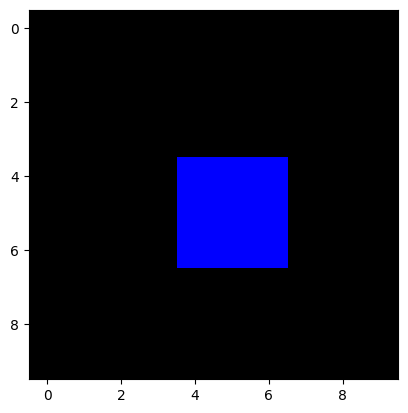

In [29]:
import matplotlib.pyplot as plt

# Two black 10x10 RGB canvases
canvases = tf.zeros((2, 10, 10, 3), dtype=tf.float32)

# A 2x4 box to draw on the first canvas, and a 3x3 box on the second
boxes = tf.constant([[1, 1, 3, 5],   # Box 1: y in [1,3), x in [1,5)
                     [4, 4, 7, 7]],  # Box 2: y in [4,7), x in [4,7)
                    dtype=tf.int32)

# Color for each box (Red for box 1, Blue for box 2)
colors = tf.constant([[1.0, 0.0, 0.0],  # Red
                      [0.0, 0.0, 1.0]],  # Blue
                     dtype=tf.float32)

updated_canvases = draw_boxes(canvases=canvases, boxes=boxes, colors=colors)

# 1. Select the first canvas from the batch and convert to NumPy
canvas_to_display = updated_canvases[1].numpy()

# 2. Use imshow to display it
plt.imshow(canvas_to_display)
plt.show() # This command actually renders the plot

## Problem \#10: Batch Image Patch Extraction with `gather_nd`

#### **Context**

The last problem was about "writing" to a tensor using `scatter`. Now let's master the inverse: "reading" specific slices from a tensor using `gather`.

A common task in computer vision is to extract small patches around a set of keypoints or "interest points" from a batch of images. For example, you might want to extract a 5x5 patch around the left eye and right eye from every face in a batch. Your challenge is to do this in a single, vectorized operation.

#### **Your Task**

Write a function `extract_patches(images, keypoints, patch_size)` that takes:

1.  `images`: A batch of images. Shape: `(batch_size, height, width, channels)`.
2.  `keypoints`: The center `(y, x)` coordinate for the patch to extract from each image. Shape: `(batch_size, 2)`.
3.  `patch_size`: A scalar odd integer (e.g., 3, 5) representing the height and width of the square patch.

The function should return a single tensor:

1.  `patches`: A tensor containing all the extracted patches. Shape: `(batch_size, patch_size, patch_size, channels)`.

-----

### Test Data

Let's create a simple batch of two 10x10 images. The first image will just be its y-coordinates, and the second will be its x-coordinates, so we can easily see where the patches came from.

```python
import tensorflow as tf

height, width = 10, 10
y_coords, x_coords = tf.meshgrid(tf.range(height), tf.range(width), indexing='ij')

# Image 0: Each pixel's value is its y-coordinate
image0 = tf.cast(tf.stack([y_coords]*3, axis=-1), dtype=tf.float32) 
# Image 1: Each pixel's value is its x-coordinate
image1 = tf.cast(tf.stack([x_coords]*3, axis=-1), dtype=tf.float32)

images = tf.stack([image0, image1], axis=0) # Shape (2, 10, 10, 3)

# Keypoint for each image in (y, x) format
keypoints = tf.constant([[3, 4],  # Center of patch for image 0
                         [6, 5]], # Center of patch for image 1
                        dtype=tf.int32)

patch_size = 3
```

#### **Sanity Check**

The keypoint for the first image is `(y=3, x=4)`. A 3x3 patch centered here will cover y-coordinates `[2, 3, 4]` and x-coordinates `[3, 4, 5]`. Since the pixel values in the first image are just their y-coordinate, the final patch should look like a `3x3` grid where the first row is all `2`s, the second row is all `3`s, and the third row is all `4`s.

In [30]:
# def extract_patches(images, keypoints, patch_size):
#     images_shape = tf.shape(images)
#     batch_size = images_shape[0]
#     image_height = images_shape[1]
#     image_width = images_shape[2]
#     images_channel = images_shape[3]

#     # step 1: convert keypoints to min/max coordinates
#     float_keypoints = tf.cast(keypoints, dtype=tf.float32)
#     # TODO: We might have to add logic to make sure min max doesn't go over the image boundry
#     y_min = tf.cast(
#         tf.floor(float_keypoints[:, 0] - (patch_size) / 2), dtype=tf.int32)
#     y_max = tf.cast(
#         tf.floor(float_keypoints[:, 0] + (patch_size) / 2), dtype=tf.int32)
#     x_min = tf.cast(
#         tf.floor(float_keypoints[:, 1] - (patch_size) / 2), dtype=tf.int32)
#     x_max = tf.cast(
#         tf.floor(float_keypoints[:, 1] + (patch_size) / 2), dtype=tf.int32)
#     min_max_coordinates = tf.stack([y_min, x_min, y_max, x_max], axis=-1)
#     print(min_max_coordinates.shape)

#     # step 2: create universal grid
#     y, x = tf.meshgrid(tf.range(image_height),
#                        tf.range(image_width), indexing="ij")
#     grid = tf.stack([y, x], axis=-1)
#     universal_grid = tf.repeat([grid], repeats=batch_size, axis=0)
#     print(universal_grid.shape)

#     # step 3: create boolean mask from universal grid for minmax coordinates
#     min_max_expanded_dims = min_max_coordinates[:, tf.newaxis, tf.newaxis, :]
#     boolean_mask = (universal_grid[:, :, :, 0] >= min_max_expanded_dims[:, :, :, 0]) & (universal_grid[:, :, :, 0] <= min_max_expanded_dims[:, :, :, 2]) & (
#         universal_grid[:, :, :, 1] >= min_max_expanded_dims[:, :, :, 1]) & (universal_grid[:, :, :, 0] <= min_max_expanded_dims[:, :, :, 3])
#     boolean_mask_indices = tf.where(boolean_mask)

#     # step 4: use the mask to extract the data using gather or gather nd.
#     extracted_patches = tf.gather_nd(
#         params=images, indices=boolean_mask_indices, batch_dims=0)
#     # temp = tf.reshape(extracted_patches, shape=(-1,
#     #                   patch_size, patch_size, images_channel))
#     return extracted_patches

In [31]:
def extract_patches(images, keypoints, patch_size):
    images_shape = tf.shape(images)
    batch_size = images_shape[0]
    image_height = images_shape[1]
    image_width = images_shape[2]
    images_channel = images_shape[3]
    # step 1: create a patch
    patch_grid_range = patch_size // 2
    patch_y,patch_x = tf.meshgrid(tf.range(-patch_grid_range,patch_grid_range+1),tf.range(-patch_grid_range,patch_grid_range+1),indexing="ij")
    patch_grid = tf.stack([patch_y,patch_x], axis=-1)

    # step 2: create image patch
    keypoints_extra_dims = keypoints[:,tf.newaxis,tf.newaxis,:]
    image_patch_indices = tf.add(keypoints_extra_dims,patch_grid)
    
    # step 3: extract patches
    print(images.shape)
    print(image_patch_indices.shape)
    batch_indices = tf.range(batch_size, dtype=tf.int32)
    batch_indices = batch_indices[:,tf.newaxis,tf.newaxis,tf.newaxis]

    ones_tensor = tf.ones(shape=(batch_size,patch_size,patch_size,1), dtype=tf.int32)
    stretched_batch_indices = tf.multiply(ones_tensor,batch_indices)

    patch_with_batch_indices = tf.concat([stretched_batch_indices,image_patch_indices],axis=-1)
    patches = tf.gather_nd(images, patch_with_batch_indices, batch_dims=0)
    return patches



In [32]:
height, width = 10, 10
y_coords, x_coords = tf.meshgrid(tf.range(height), tf.range(width), indexing='ij')

# Image 0: Each pixel's value is its y-coordinate
image0 = tf.cast(tf.stack([y_coords]*3, axis=-1), dtype=tf.float32) 
# Image 1: Each pixel's value is its x-coordinate
image1 = tf.cast(tf.stack([x_coords]*3, axis=-1), dtype=tf.float32)

images = tf.stack([image0, image1], axis=0) # Shape (2, 10, 10, 3)

# Keypoint for each image in (y, x) format
keypoints = tf.constant([[3, 4],  # Center of patch for image 0
                         [6, 5]], # Center of patch for image 1
                        dtype=tf.int32)

patch_size = 3

extracted_patches = extract_patches(images=images,keypoints=keypoints,patch_size=patch_size)
extracted_patches

(2, 10, 10, 3)
(2, 3, 3, 2)


<tf.Tensor: shape=(2, 3, 3, 3), dtype=float32, numpy=
array([[[[2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.]],

        [[3., 3., 3.],
         [3., 3., 3.],
         [3., 3., 3.]],

        [[4., 4., 4.],
         [4., 4., 4.],
         [4., 4., 4.]]],


       [[[4., 4., 4.],
         [5., 5., 5.],
         [6., 6., 6.]],

        [[4., 4., 4.],
         [5., 5., 5.],
         [6., 6., 6.]],

        [[4., 4., 4.],
         [5., 5., 5.],
         [6., 6., 6.]]]], dtype=float32)>

# Problem #11: Batched Tensor Rolling

## **Context**

A "roll" or "circular shift" is an operation where the pixels of an image that are shifted off one edge wrap around to the opposite edge. It's a common data augmentation technique. The challenge is to perform a *different* roll for each image in a batch.

## **Your Task**

Write a function `batch_roll(images, shifts)` that takes:

1.  `images`: A batch of images. Shape: `(batch_size, height, width, channels)`.
2.  `shifts`: The `(dy, dx)` shifts for each image. Shape: `(batch_size, 2)`. `dy` is the vertical shift, `dx` is the horizontal shift.

The function should return a single tensor:

1.  `rolled_images`: The batch of images, with each image shifted according to its corresponding `(dy, dx)` vector. The shape should be unchanged.

### **Core Challenge**

This is a pure `gather` problem. For each destination pixel `(y, x)` in the output, you need to calculate which pixel `(source_y, source_x)` to grab from the input image. The circular wrapping can be achieved with the modulo operator (`%`).

-----

### Test Data

```python
import tensorflow as tf

# Create a simple 5x5 image with a cross shape
image = tf.constant([[0,0,1,0,0],
                     [0,0,1,0,0],
                     [1,1,1,1,1],
                     [0,0,1,0,0],
                     [0,0,1,0,0]], dtype=tf.float32)
image = tf.expand_dims(image, axis=-1) # Add channel dim -> (5,5,1)

# Create a batch of two identical images
images = tf.stack([image, image], axis=0) # Shape (2, 5, 5, 1)

# Shift the first image down by 1 and right by 1
# Shift the second image up by 1 and left by 2
shifts = tf.constant([[1, 1],   # [dy, dx] for image 0
                     [-1, -2]], # [dy, dx] for image 1
                    dtype=tf.int32)
```

### **Sanity Check**

The cross in the first output image (`rolled_images[0]`) should be shifted down and to the right, with the parts that go off the edge wrapping around to the top and left.

#### Thoughts
* Here shifts is not the index of row or columns, but rather magnitude and direction of shift
* So if the shift is positive we need to go down or right,i.e. we need to roll last `n` rows or columns to the top. If shift is 1 then roll 1 last 1 row if shift is 2 roll last 2 rows
* Similarly if the shift is negative we need to go up or left and so need to roll first `n` rows or columns to the bottom. 
* Negating the shift values will tell us which rows to roll and their values will tell us where to shift. I think.
* I was wrong here, `gather_nd` does not work with negative indices. 
* Also to read the columns, I'll need seperate indices for each row and column value. 

#### New Approach
* We need to use modulo operator to find the threshold index which can be used to move the rows and columns for the roll
* Lets assume 5x5 image

##### Vertical Roll

```bash
Shifting Up with -tve shifts 
-5%5,-4%5,-3%5,-2%5,-1%5 = (0, 1, 2, 3, 4)

- -5 means do nothing
- -4 means shift 4 rows up, which is same as moving the last row to the top. Which means create a mask to move `row index 4 (last row)` to the top. 
- -3 means shift 3 rows up, which is same as moving last 2 rows to the top. Which means create a mask to move `row index 3 and 4 (last 2 rows)` to the top. 
- -2 means shift 2 rows up, which is same as moving last 3 rows to the top. Which means create a mask to move `row index 2, 3 and 4 (last 3 rows)` to the top. 
- This can be generalized by using the modulo value. Subtracting modulo value from total rows gives us the threshold index above which are the shift indices and below which are the roll indices. 
- so for -4, module is 1, so threshold is 5 - 1 = 4, move rows 4 and above to the top. 
- for -3, modulo is 2, so threshold is 5 - 2 = 3, move rows 3 and above to the top

Shifting Down with +tve shifts 

5%5,4%5,3%5,2%5,1%5 = (0, 4, 3, 2, 1)

- 5 means do nothing
- 4 means shift 4 rows down, which is same as moving last 4 rows to the top i.e. threshold would be 5 - 4 = 1, move rows 1 and above to the top
- 3 means shift 3 rows down, which is same as moving last 3 rows to the top i.e. threshold would be 5 - 3 = 2 move rows 2 and above to the top
```

##### Horizontal roll
* We can use similar approach as positive roll to this

```bash
Shifting left with -tive shift 
-5%5,-4%5,-3%5,-2%5,-1%5 = (0, 1, 2, 3, 4)

- -5 means do nothing
- -4 means shift 4 cols  left, is same is moving last col to the left most position. i.e. threshold would be 5 - 1 = 4 move columns 4 and above to the left
- -3 means shift 3 cols  left, is same is moving last 2 col to the left most position. i.e. threshold would be 5 - 2 = 3 move columns 3 and above to the left
- and so on

Shifting right with +tive shift 

5%5,4%5,3%5,2%5,1%5 = (0, 4, 3, 2, 1)

- 5 means do nothing
- 4 emans shift 4 cols right, is same as moving last 4 colors to the left most position. i.e threshold would be 5 - 4 = 1, move columns 1 and above to the left. 
- and so on. 

```
* We can then create boolean mask to select rows and columns
* Ok this won't work because `tf.where` and `tf.gather` looses the 2D structure of the image. 
* We just have to use the formula `source = (destination - dy)%height` to map source pixels to destination pixels


In [168]:
def batch_roll(images, shifts):
    ## get input shape
    batch_size,image_width,image_height, channels = images.shape.as_list()
    
    
    ## create blank universal grid
    y, x = tf.meshgrid(tf.range(image_width), tf.range(image_height), indexing="ij")
    # universal grid
    universal_grid = tf.stack(values=[y, x], axis=-1)
    # extend the universal grid with batch size
    universal_grid = tf.repeat([universal_grid], repeats=batch_size, axis=0)
    
    # extend shifts for broadcasting
    extended_shifts = shifts[:,tf.newaxis,tf.newaxis,:]

    vertical_shift_sources = (universal_grid[:,:,:,0] - extended_shifts[:,:,:,0]) % image_height
    horizontal_shift_sources = (universal_grid[:,:,:,1] - extended_shifts[:,:,:,1]) % image_width
    
    shift_sources = tf.stack([vertical_shift_sources,horizontal_shift_sources],axis = -1)
    print(shift_sources.shape)

    batch_indices = tf.range(batch_size, dtype=tf.int32)
    batch_indices = batch_indices[:,tf.newaxis,tf.newaxis,tf.newaxis]

    ones_tensor = tf.ones(shape=(batch_size,image_height,image_width,1), dtype=tf.int32)
    stretched_batch_indices = tf.multiply(ones_tensor,batch_indices)

    
    shift_sources_batch_indices = tf.concat([stretched_batch_indices,shift_sources],axis=-1)
    print(shift_sources_batch_indices.shape)
    print(images.shape)
    rolled_images = tf.gather_nd(images,indices=shift_sources_batch_indices,batch_dims=0)
    return rolled_images

In [169]:
# Create a simple 5x5 image with a cross shape
image = tf.constant([[0,0,1,0,0],
                     [0,0,1,0,0],
                     [1,1,1,1,1],
                     [0,0,1,0,0],
                     [0,0,1,0,0]], dtype=tf.float32)
image = tf.expand_dims(image, axis=-1) # Add channel dim -> (5,5,1)

# Create a batch of two identical images
images = tf.stack([image, image], axis=0) # Shape (2, 5, 5, 1)

# Shift the first image down by 1 and right by 1
# Shift the second image up by 1 and left by 2
shifts = tf.constant([[1, 1],   # [dy, dx] for image 0
                     [-1, -2]], # [dy, dx] for image 1
                    dtype=tf.int32)

rolled_images = batch_roll(images=images,shifts=shifts)
rolled_images

(2, 5, 5, 2)
(2, 5, 5, 3)
(2, 5, 5, 1)


<tf.Tensor: shape=(2, 5, 5, 1), dtype=float32, numpy=
array([[[[0.],
         [0.],
         [0.],
         [1.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         [1.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         [1.],
         [0.]],

        [[1.],
         [1.],
         [1.],
         [1.],
         [1.]],

        [[0.],
         [0.],
         [0.],
         [1.],
         [0.]]],


       [[[1.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[1.],
         [1.],
         [1.],
         [1.],
         [1.]],

        [[1.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[1.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[1.],
         [0.],
         [0.],
         [0.],
         [0.]]]], dtype=float32)>

In [100]:
image = tf.constant([[0,0,1,0,0],
                     [0,0,1,0,0],
                     [1,1,1,1,1],
                     [0,0,1,0,0],
                     [0,0,1,0,0]], dtype=tf.float32)
image = tf.expand_dims(image, axis=-1) # Add channel dim -> (5,5,1)

# Create a batch of two identical images
images = tf.stack([image, image], axis=0) # Shape (2, 5, 5, 1)

# Shift the first image down by 1 and right by 1
# Shift the second image up by 1 and left by 2
shifts = tf.constant([[1, 1],   # [dy, dx] for image 0
                     [-1, -2]], # [dy, dx] for image 1
                    dtype=tf.int32)
# create indices for rows to roll
## read the vertical shifts
rows_roll_indices = shifts[:,0]
## negate the shift value to get indices range to roll
rows_roll_indices = rows_roll_indices * -1
print(rows_roll_indices)
print(f"rows_roll_indices.shape {rows_roll_indices.shape}")

## hardcoded POC
## shifting down by 1
## read last row
last_row_index = [0,4] ## 0th image, 5th row
# rows_to_shift = [0,0],[0,1],[0,2],[0,3]
gathered_stuff = tf.gather_nd(images,indices=[[[0,4],[0,0],[0,1],[0,2],[0,3]]],batch_dims=0)
gathered_stuff

## reading last column from gathered stuff
gathered_stuff_col = tf.gather_nd(gathered_stuff,indices=[[[0,0,0],[0,1,0],[0,2,0],[0,3,0],[0,4,0]]],batch_dims=0)
gathered_stuff_col

tf.Tensor([-1  1], shape=(2,), dtype=int32)
rows_roll_indices.shape (2,)


<tf.Tensor: shape=(1, 5, 1), dtype=float32, numpy=
array([[[0.],
        [0.],
        [0.],
        [1.],
        [0.]]], dtype=float32)>

[2, 5, 5, 1]

In [111]:
## shifting up
-5%5,-4%5,-3%5,-2%5,-1%5

(0, 1, 2, 3, 4)

In [112]:
5%5,4%5,3%5,2%5,1%5

(0, 4, 3, 2, 1)